In [46]:
# %load test_timm.py
import os
import time

import matplotlib.pyplot as plt
import torch
from timm.models import create_model
from timm.models.vision_transformer import VisionTransformer
from torch.cuda.amp import GradScaler, autocast


def train(model, input, amp_enable=False, warmup=False):
    for i in range(0, 3):
        with autocast(enabled=amp_enable):
            out=model(input)
        out.sum().backward()
    torch.cuda.synchronize()
    time_start=time.time()
    for i in range(0, 10):
        with autocast(enabled=amp_enable):
            out=model(input)
        out.sum().backward()

    torch.cuda.synchronize()
    if not warmup:
        print(f'time used: {time.time()-time_start}')
    return time.time()-time_start


def train_g(model, input, amp_enable=False, warmup=False):
    # Placeholders used for capture
    static_input = torch.randn_like(input, device='cuda')
    g = torch.cuda.CUDAGraph()
    with torch.cuda.graph(g):
        with autocast(enabled=amp_enable):
            out=model(static_input)
        out.sum().backward()

    static_input.copy_(input)
    torch.cuda.synchronize()
    time_start=time.time()
    for i in range(0, 5):
        g.replay()

    torch.cuda.synchronize()
    if not warmup:
        print(f'time used: {time.time()-time_start}')

def train_g_2(model, input, amp_enable=False, warmup=False):
    torch.cuda.synchronize()
    model_g = torch.cuda.make_graphed_callables(model, (input,))
    time_start=time.time()
    for i in range(0, 5):
        with autocast(enabled=amp_enable):
            out=model_g(input)
        out.sum().backward()

    torch.cuda.synchronize()
    print(f'time used: {time.time()-time_start}')

def run_train_funcs(train, model, input):
    # warmup, ignore
    train(model, input, warmup=True)

    # torch.backends.cuda.matmul.allow_tf32=False
    # torch.backends.cudnn.allow_tf32=False
    os.environ['NVIDIA_TF32_OVERRIDE']='0'
    print('----train with fp32----')
    train(model, input)
    print('----train with autocast----')
    train(model, input, amp_enable=True)
    print('----train with tf32----')
    os.environ['NVIDIA_TF32_OVERRIDE']='1'
    torch.backends.cuda.matmul.allow_tf32=True
    torch.backends.cudnn.allow_tf32=True
    train(model, input)

print(torch.backends.cuda.matmul.allow_tf32)
print(torch.backends.cudnn.allow_tf32)

def enable_tf32():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

def disable_tf32():
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = True

True
True


In [58]:
import pandas
    

In [61]:


def train_multi_batchs(model,shape):
    times=[]
    ips=[]
    batchs=[1,2,4,8,16,32,48,64,96,128]
    for b in batchs:
        shape[0]=b
        input=torch.rand(shape).cuda()
        try:
            time_used = train(model, input)
            batch_per_second = b/time_used
            time_per_batch = time_used/b
            times.append(time_per_batch)
            ips.append(batch_per_second)
        except:
            time_used=float('inf')
            batchs.remove(b)
        

    ratios=[]
    ips_ratios=[]
    for i in range(len(times)):
        # this is equal to ips[i]/ips[0]
        ratios.append(round(times[0]/times[i],3))
        ips_ratios.append(ips[i]/ips[0])
    
    increase = []
    for i in range(len(ratios)):
        pre=0 if i-1<0 else i-1
        increase.append(round(ratios[i]/ratios[pre],3))
    print(ratios)
    print(increase)
    dct = {'batch': batchs, 'speedup': increase}
    print(pandas.DataFrame.from_dict(dct))
    
    plt.plot(batchs, ratios, '-', label='ratio to batch=1')
    plt.plot(batchs, increase, '+', label='ratio to last')
    plt.legend()
    plt.show()


In [50]:
enable_tf32()
model=create_model('vit_large_patch16_384', #vit_large_patch16_384
                   pretrained=False,
                   num_classes=None,
                   drop_rate=0,
                   drop_path_rate=0.3)
model.cuda().train()
a=1

time used: 0.40386271476745605
time used: 0.5598673820495605
time used: 0.9959065914154053
time used: 1.8195843696594238
time used: 3.4365298748016357
time used: 6.695101261138916
time used: 9.986263036727905
[1.0, 1.4444447755818166, 1.6242021643920148, 1.7778764112198802, 1.880133991997554, 1.9319277070700227, 1.93952627871851]
[1.0, 1.4444447755818166, 1.1244473944930105, 1.094615221058636, 1.0575166980856168, 1.0275478850405977, 1.0039331552731916]


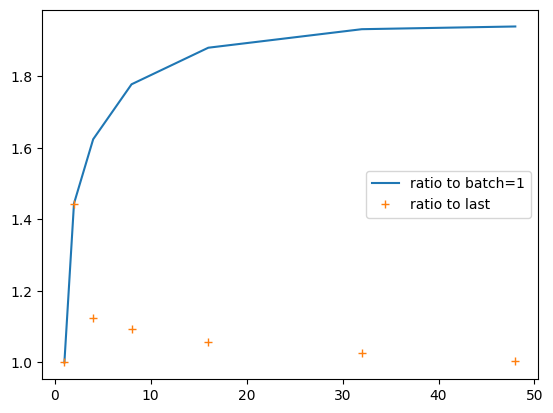

In [51]:
train_multi_batchs(model,[1,3,384,384])

In [ ]:
enable_tf32()
model=create_model('vit_large_patch16_384', #vit_large_patch16_384
                   pretrained=False,
                   num_classes=None,
                   drop_rate=0,
                   drop_path_rate=0.3)
model.cuda().train()


time used: 0.9444370269775391
time used: 1.723750352859497
time used: 3.158313751220703
time used: 6.0927414894104
time used: 11.841182231903076
time used: 23.52548837661743
time used: 35.22850513458252
[1.0, 1.0965497898385645, 1.1888803986392142, 1.2400350752308338, 1.2754278359712121, 1.2849777624139533, 1.2868839589275554]
[1.0, 1.0965497898385645, 1.0842010181901933, 1.0430276053421108, 1.0285417416388725, 1.0074876258565182, 1.0014834470831784]


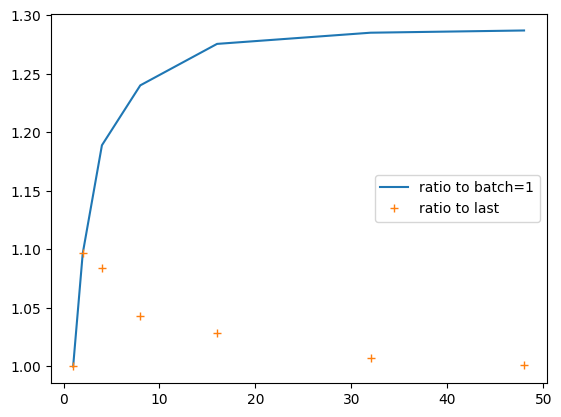

In [52]:
disable_tf32()
model1=create_model('vit_large_patch16_384', #vit_large_patch16_384
                   pretrained=False,
                   num_classes=None,
                   drop_rate=0,
                   drop_path_rate=0.3)
model1.cuda().train()
train_multi_batchs(model,[1,3,384,384])

time used: 0.18927526473999023
time used: 0.22405433654785156
time used: 0.33617258071899414
time used: 0.6050307750701904
time used: 1.1481497287750244
time used: 2.183502674102783
time used: 3.2543933391571045
time used: 4.240720272064209
[1.0, 1.6953355483706922, 2.259972131711347, 2.511355187816355, 2.646982083172501, 2.78342403556328, 2.788532686812383, 2.8663772467392477]


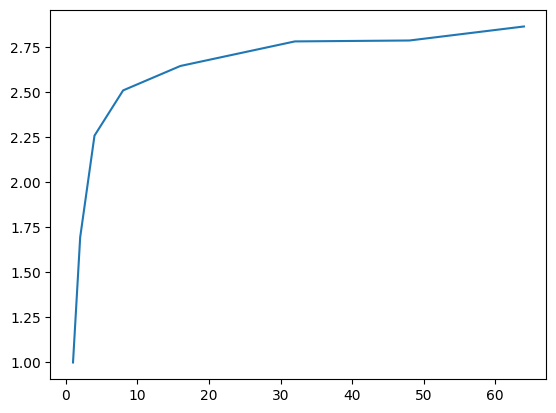

In [19]:
train_multi_batchs(model1, [1,3,224,224])

time used: 0.1989448070526123
time used: 0.2245173454284668
time used: 0.3356807231903076
time used: 0.6044712066650391
time used: 1.1483781337738037
time used: 2.180988073348999
time used: 3.2414636611938477
time used: 4.2371742725372314
time used: 6.363129377365112
time used: 8.376313209533691
[1.0, 1.777, 2.378, 2.641, 2.781, 2.929, 2.935, 3.012, 3.012, 3.044]
[1.0, 1.777, 1.338, 1.111, 1.053, 1.053, 1.002, 1.026, 1.0, 1.011]
   batch  speedup
0      1    1.000
1      2    1.777
2      4    1.338
3      8    1.111
4     16    1.053
5     32    1.053
6     48    1.002
7     64    1.026
8     96    1.000
9    128    1.011


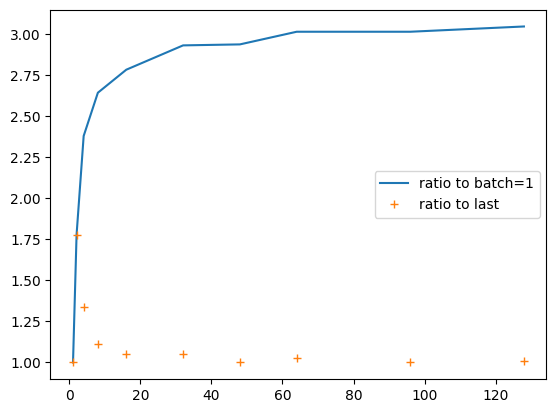

In [66]:
disable_tf32()
model1=create_model('vit_base_patch16_224', #vit_large_patch16_384
                   pretrained=False,
                   num_classes=None,
                   drop_rate=0,
                   drop_path_rate=0.3)
model1.cuda().train()
train_multi_batchs(model1,[1,3,224,224])


